In [1]:
# read jsons for participant and model data
import json
import numpy as np

participant_file = 'x_participant_data.json'
model_file = 'x_model_data.json'
correct_file = 'x_correct_answers.json'

from math import sqrt
from scipy.stats import norm


with open(participant_file) as f:
    participant_data = json.load(f)
with open(model_file) as f:
    model_data = json.load(f)
with open(correct_file) as f:
    correct_data = json.load(f)

In [2]:
def binomial_confidence_interval(successes, trials, confidence_level=0.95):
    p = successes / trials
    z = norm.ppf((1 + confidence_level) / 2)

    interval = z * sqrt((p * (1 - p)) / trials)
    return interval

In [3]:
collapse = None 

In [4]:
def transform_answer(answer, froma, toa):
    if answer.strip().lower() == froma:
        return toa
    else:
        return answer

In [5]:
condition_num_participants = {}
for condition_names in participant_data.keys():
    # count number of participants
    for scenario_id in range(10):
        participant_answers = participant_data[condition_names][scenario_id]
        if condition_names not in condition_num_participants:
            condition_num_participants[condition_names] = 0
        condition_num_participants[condition_names] += len(participant_answers)

In [6]:
print(participant_data.keys())

dict_keys(['safety_expected/belief_a_surprised_0', 'safety_expected/belief_b_surprised_1', 'safety_expected/outcome_relieved_1', 'goal_control/outcome_joyful_1', 'goal_control/belief_b_grateful_1', 'goal_control/emotion_grateful_0', 'goal_control/outcome_grateful_1', 'safety_expected/outcome_surprised_1', 'safety_expected/emotion_surprised_0', 'goal_control/emotion_disappointed_0', 'safety_expected/outcome_relieved_0', 'safety_expected/emotion_resigned_0', 'goal_control/outcome_disappointed_0', 'goal_control/belief_b_disappointed_0', 'safety_expected/outcome_surprised_0', 'goal_control/belief_b_joyful_1', 'goal_control/outcome_disappointed_1', 'safety_expected/belief_b_resigned_1', 'safety_expected/outcome_resigned_0', 'goal_control/belief_a_frustrated_0', 'goal_control/belief_a_disappointed_0', 'goal_control/belief_a_grateful_0', 'goal_control/belief_a_joyful_0', 'safety_expected/belief_a_devastated_0', 'safety_expected/belief_a_relieved_0', 'safety_expected/belief_a_resigned_0', 'goa

In [7]:
pp_agreement_scores = {}
mode = 'majority'
hold = True 
# calculate agreement between participants
if collapse == None:
    for condition_names in participant_data.keys():

        if condition_names not in pp_agreement_scores:
            pp_agreement_scores[condition_names] = []

        for scenario_id in range(10):
            participant_answers = participant_data[condition_names][scenario_id]
            participant_answers = [a.strip().lower() for a in participant_answers]

            # calculate agreement with hold-one-out majority vote
            average_hold_one_out = []
            for i in range(len(participant_answers)):
                if hold:
                    hold_one_out = [a for j, a in enumerate(participant_answers) if j != i]
                else:
                    hold_one_out = participant_answers
                # count answers
                answer_counts = {}
                for a in hold_one_out:
                    if a not in answer_counts:
                        answer_counts[a] = 0
                    answer_counts[a] += 1
                # average hold-one-out
                total_ans = len(hold_one_out)
                answer_counts = {k: v / total_ans for k, v in answer_counts.items()}
                # get majority answer
                majority_answer = max(answer_counts, key=answer_counts.get)

                answer = participant_answers[i]
                if mode == "average":
                    if answer not in answer_counts:
                        pp_agreement_scores[condition_names].append(0)
                    else:
                        pp_agreement_scores[condition_names].append(answer_counts[answer])
                elif mode == "majority":
                    pp_agreement_scores[condition_names].append(1 if answer == majority_answer else 0)


In [8]:
# calculate accuracy of participants
pp_acc_scores = {}
pp_maj_acc_scores = {}
if collapse == None:
    for condition_names in participant_data.keys():
        if condition_names not in pp_acc_scores:
            pp_acc_scores[condition_names] = []
            pp_maj_acc_scores[condition_names] = []
        for scenario_id in range(10):
            participant_answers = participant_data[condition_names][scenario_id]
            if condition_names not in condition_num_participants:
                condition_num_participants[condition_names] = 0
            condition_num_participants[condition_names] += len(participant_answers)
            correct_answer = correct_data[condition_names][str(scenario_id)]
            maj = 0
            for i, answer in enumerate(participant_answers):
                if answer.strip().lower() == correct_answer.strip().lower():
                    pp_acc_scores[condition_names].append(1)
                    maj += 1
                else:
                    pp_acc_scores[condition_names].append(0)
            if maj / len(participant_answers) >= 0.5:
                pp_maj_acc_scores[condition_names].append(1)  
            else:
                pp_maj_acc_scores[condition_names].append(0)

In [9]:
# show agreement by inference method
# calculate agreement by inferences
model_means = {}
model_sems = {}
pp_means = {}
pp_sems = {}
emotion_inference_safety_expected = []
emotion_inference_goal_control = []
control_inference = []
goal_inference = []
safety_inference = []
expected_inference = []
outcome_inference_safety_expected = []
outcome_inference_goal_control = []
agreements = pp_agreement_scores
p_nums = {}

model_means["interparticipant"] = {}
model_sems["interparticipant"] = {}
for condition in agreements:
    if "safety_expected" in condition and "emotion" in condition:
        emotion_inference_safety_expected += agreements[condition]
        if "emotion_inference_safety_expected" not in p_nums:
            p_nums["emotion_inference_safety_expected"] = 0
        p_nums["emotion_inference_safety_expected"] += condition_num_participants[condition]
    elif "goal_control" in condition and "emotion" in condition:
        emotion_inference_goal_control += agreements[condition]
        if "emotion_inference_goal_control" not in p_nums:
            p_nums["emotion_inference_goal_control"] = 0
        p_nums["emotion_inference_goal_control"] += condition_num_participants[condition]
    elif "goal_control" in condition and "belief_a" in condition:
        control_inference += agreements[condition]
        if "control_inference" not in p_nums:
            p_nums["control_inference"] = 0
        p_nums["control_inference"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "belief_a" in condition:
        expected_inference += agreements[condition]
        if "expected_inference" not in p_nums:
            p_nums["expected_inference"] = 0
        p_nums["expected_inference"] += condition_num_participants[condition]
    elif "goal_control" in condition and "belief_b" in condition:
        goal_inference += agreements[condition]
        if "goal_inference" not in p_nums:
            p_nums["goal_inference"] = 0
        p_nums["goal_inference"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "belief_b" in condition:
        safety_inference += agreements[condition]
        if "safety_inference" not in p_nums:
            p_nums["safety_inference"] = 0
        p_nums["safety_inference"] += condition_num_participants[condition]
    elif "goal_control" in condition and "outcome" in condition:
        outcome_inference_goal_control += agreements[condition]
        if "outcome_inference_goal_control" not in p_nums:
            p_nums["outcome_inference_goal_control"] = 0
        p_nums["outcome_inference_goal_control"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "outcome" in condition:
        outcome_inference_safety_expected += agreements[condition]
        if "outcome_inference_safety_expected" not in p_nums:
            p_nums["outcome_inference_safety_expected"] = 0
        p_nums["outcome_inference_safety_expected"] += condition_num_participants[condition]

model_method = "interparticipant"
model_means[model_method]["emotion_inference_safety_expected"] = np.mean(emotion_inference_safety_expected)
model_sems[model_method]["emotion_inference_safety_expected"] = 1.96 * np.std(emotion_inference_safety_expected) / np.sqrt(p_nums["emotion_inference_safety_expected"])
model_means[model_method]["emotion_inference_goal_control"] = np.mean(emotion_inference_goal_control)
model_sems[model_method]["emotion_inference_goal_control"] = 1.96 * np.std(emotion_inference_goal_control) / np.sqrt(p_nums["emotion_inference_goal_control"])
model_means[model_method]["control_inference"] = np.mean(control_inference)
model_sems[model_method]["control_inference"] = 1.96 * np.std(control_inference) / np.sqrt(p_nums["control_inference"])
model_means[model_method]["expected_inference"] = np.mean(expected_inference)
model_sems[model_method]["expected_inference"] = 1.96 * np.std(expected_inference) / np.sqrt(p_nums["expected_inference"])
model_means[model_method]["goal_inference"] = np.mean(goal_inference)
model_sems[model_method]["goal_inference"] = 1.96 * np.std(goal_inference) / np.sqrt(p_nums["goal_inference"])
model_means[model_method]["safety_inference"] = np.mean(safety_inference)
model_sems[model_method]["safety_inference"] = 1.96 * np.std(safety_inference) / np.sqrt(p_nums["safety_inference"])
model_means[model_method]["outcome_inference_goal_control"] = np.mean(outcome_inference_goal_control)
model_sems[model_method]["outcome_inference_goal_control"] = 1.96 * np.std(outcome_inference_goal_control) / np.sqrt(p_nums["outcome_inference_goal_control"])
model_means[model_method]["outcome_inference_safety_expected"] = np.mean(outcome_inference_safety_expected)
model_sems[model_method]["outcome_inference_safety_expected"] = 1.96 * np.std(outcome_inference_safety_expected) / np.sqrt(p_nums["outcome_inference_safety_expected"])

print("Agreement by inference", model_method)
print("Emotion inference safety expected: ", model_means[model_method]["emotion_inference_safety_expected"], model_sems[model_method]["emotion_inference_safety_expected"])
print("Emotion inference goal control: ", model_means[model_method]["emotion_inference_goal_control"], model_sems[model_method]["emotion_inference_goal_control"])
print("Control inference: ", model_means[model_method]["control_inference"], model_sems[model_method]["control_inference"])
print("Expected inference: ", model_means[model_method]["expected_inference"], model_sems[model_method]["expected_inference"])
print("Goal inference: ", model_means[model_method]["goal_inference"], model_sems[model_method]["goal_inference"])
print("Safety inference: ", model_means[model_method]["safety_inference"], model_sems[model_method]["safety_inference"])
print("Outcome inference goal control: ", model_means[model_method]["outcome_inference_goal_control"], model_sems[model_method]["outcome_inference_goal_control"])
print("Outcome inference safety expected: ", model_means[model_method]["outcome_inference_safety_expected"], model_sems[model_method]["outcome_inference_safety_expected"])

Agreement by inference interparticipant
Emotion inference safety expected:  0.7473610133708656 0.015975683180377637
Emotion inference goal control:  0.6800286327845383 0.01729665123721122
Control inference:  0.7396780965710287 0.01608798652873702
Expected inference:  0.6131541725601132 0.017950236347891807
Goal inference:  0.8019732205778718 0.014661951254988523
Safety inference:  0.7467994310099573 0.01607247433797217
Outcome inference goal control:  0.8395759717314487 0.013521583756815898
Outcome inference safety expected:  0.835799859055673 0.013629746716850794


In [10]:
# show agreement by inference method
# calculate agreement by inferences
pp_means = {}
pp_sems = {}
emotion_inference_safety_expected = []
emotion_inference_goal_control = []
control_inference = []
goal_inference = []
safety_inference = []
expected_inference = []
outcome_inference_safety_expected = []
outcome_inference_goal_control = []
agreements = pp_acc_scores
p_nums = {}

model_means["accuracy"] = {}
model_sems["accuracy"] = {}
for condition in agreements:
    if "safety_expected" in condition and "emotion" in condition:
        emotion_inference_safety_expected += agreements[condition]
        if "emotion_inference_safety_expected" not in p_nums:
            p_nums["emotion_inference_safety_expected"] = 0
        p_nums["emotion_inference_safety_expected"] += condition_num_participants[condition]
    elif "goal_control" in condition and "emotion" in condition:
        emotion_inference_goal_control += agreements[condition]
        if "emotion_inference_goal_control" not in p_nums:
            p_nums["emotion_inference_goal_control"] = 0
        p_nums["emotion_inference_goal_control"] += condition_num_participants[condition]
    elif "goal_control" in condition and "belief_a" in condition:
        control_inference += agreements[condition]
        if "control_inference" not in p_nums:
            p_nums["control_inference"] = 0
        p_nums["control_inference"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "belief_a" in condition:
        expected_inference += agreements[condition]
        if "expected_inference" not in p_nums:
            p_nums["expected_inference"] = 0
        p_nums["expected_inference"] += condition_num_participants[condition]
    elif "goal_control" in condition and "belief_b" in condition:
        goal_inference += agreements[condition]
        if "goal_inference" not in p_nums:
            p_nums["goal_inference"] = 0
        p_nums["goal_inference"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "belief_b" in condition:
        safety_inference += agreements[condition]
        if "safety_inference" not in p_nums:
            p_nums["safety_inference"] = 0
        p_nums["safety_inference"] += condition_num_participants[condition]
    elif "goal_control" in condition and "outcome" in condition:
        outcome_inference_goal_control += agreements[condition]
        if "outcome_inference_goal_control" not in p_nums:
            p_nums["outcome_inference_goal_control"] = 0
        p_nums["outcome_inference_goal_control"] += condition_num_participants[condition]
    elif "safety_expected" in condition and "outcome" in condition:
        outcome_inference_safety_expected += agreements[condition]
        if "outcome_inference_safety_expected" not in p_nums:
            p_nums["outcome_inference_safety_expected"] = 0
        p_nums["outcome_inference_safety_expected"] += condition_num_participants[condition]

model_method = "accuracy"
model_means[model_method]["emotion_inference_safety_expected"] = np.mean(emotion_inference_safety_expected)
model_sems[model_method]["emotion_inference_safety_expected"] = 1.96 * np.std(emotion_inference_safety_expected) / np.sqrt(p_nums["emotion_inference_safety_expected"])
model_means[model_method]["emotion_inference_goal_control"] = np.mean(emotion_inference_goal_control)
model_sems[model_method]["emotion_inference_goal_control"] = 1.96 * np.std(emotion_inference_goal_control) / np.sqrt(p_nums["emotion_inference_goal_control"])
model_means[model_method]["control_inference"] = np.mean(control_inference)
model_sems[model_method]["control_inference"] = 1.96 * np.std(control_inference) / np.sqrt(p_nums["control_inference"])
model_means[model_method]["expected_inference"] = np.mean(expected_inference)
model_sems[model_method]["expected_inference"] = 1.96 * np.std(expected_inference) / np.sqrt(p_nums["expected_inference"])
model_means[model_method]["goal_inference"] = np.mean(goal_inference)
model_sems[model_method]["goal_inference"] = 1.96 * np.std(goal_inference) / np.sqrt(p_nums["goal_inference"])
model_means[model_method]["safety_inference"] = np.mean(safety_inference)
model_sems[model_method]["safety_inference"] = 1.96 * np.std(safety_inference) / np.sqrt(p_nums["safety_inference"])
model_means[model_method]["outcome_inference_goal_control"] = np.mean(outcome_inference_goal_control)
model_sems[model_method]["outcome_inference_goal_control"] = 1.96 * np.std(outcome_inference_goal_control) / np.sqrt(p_nums["outcome_inference_goal_control"])
model_means[model_method]["outcome_inference_safety_expected"] = np.mean(outcome_inference_safety_expected)
model_sems[model_method]["outcome_inference_safety_expected"] = 1.96 * np.std(outcome_inference_safety_expected) / np.sqrt(p_nums["outcome_inference_safety_expected"])

print("Agreement by inference", model_method)
print("Emotion inference safety expected: ", model_means[model_method]["emotion_inference_safety_expected"], model_sems[model_method]["emotion_inference_safety_expected"])
print("Emotion inference goal control: ", model_means[model_method]["emotion_inference_goal_control"], model_sems[model_method]["emotion_inference_goal_control"])
print("Control inference: ", model_means[model_method]["control_inference"], model_sems[model_method]["control_inference"])
print("Expected inference: ", model_means[model_method]["expected_inference"], model_sems[model_method]["expected_inference"])
print("Goal inference: ", model_means[model_method]["goal_inference"], model_sems[model_method]["goal_inference"])
print("Safety inference: ", model_means[model_method]["safety_inference"], model_sems[model_method]["safety_inference"])
print("Outcome inference goal control: ", model_means[model_method]["outcome_inference_goal_control"], model_sems[model_method]["outcome_inference_goal_control"])
print("Outcome inference safety expected: ", model_means[model_method]["outcome_inference_safety_expected"], model_sems[model_method]["outcome_inference_safety_expected"])

Agreement by inference accuracy
Emotion inference safety expected:  0.5714285714285714 0.01819435304589368
Emotion inference goal control:  0.5404438081603435 0.018479382469981053
Control inference:  0.49545136459062283 0.01833061312469611
Expected inference:  0.5756718528995757 0.018216074214097367
Goal inference:  0.8090204369274137 0.0144618239310141
Safety inference:  0.5526315789473685 0.018378028666835862
Outcome inference goal control:  0.8459363957597174 0.013300921665733005
Outcome inference safety expected:  0.6758280479210712 0.017220894247283992


In [11]:
model_method = "chance"

model_means[model_method] = {}
model_sems[model_method] = {}
model_means[model_method]["emotion_inference_safety_expected"] = 1.0/(4)
model_sems[model_method]["emotion_inference_safety_expected"] = 0
model_means[model_method]["emotion_inference_goal_control"] = 1.0/(4)
model_sems[model_method]["emotion_inference_goal_control"] = 0
model_means[model_method]["control_inference"] = 1.0/2
model_sems[model_method]["control_inference"] = 0
model_means[model_method]["expected_inference"] = 1.0/2
model_sems[model_method]["expected_inference"] = 0
model_means[model_method]["goal_inference"] = 1./2
model_sems[model_method]["goal_inference"] = 0
model_means[model_method]["safety_inference"] = 1./2
model_sems[model_method]["safety_inference"] = 0
model_means[model_method]["outcome_inference_goal_control"] = 1./2
model_sems[model_method]["outcome_inference_goal_control"] = 0
model_means[model_method]["outcome_inference_safety_expected"] = 1./2
model_sems[model_method]["outcome_inference_safety_expected"] = 0


### Summary

**GOAL-CONTROL**
- backward inference for control is low and goal is high
- if we collapse emotions for control, emotion inference rises: grateful = joyful, frustrated = disappointed
- outcome inference is high (does not depend on control, goal is the main driver)
- collapsing leads to almost the same acc as outcome

**SAFETY-EXPECTED**
- backward inference for safety and expected is not as low as control, but not as high as goal
- if we collapse emotions for safety, emotion inference rises but not as much as goal: devastated = surprised, resigned = relieved 
- if we collapse emotions for expected, emotion inference rises but not as much as goal: surprised = relieved, devastated = resigned 
- outcome inference is high but not as much as goal-control
- collapsing leads to almost the same acc as outcome


In [12]:
# plot agreement by inference method for different models and participants
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine(left=True, bottom=False)
# Set the font globally
plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 12

import colorsys
def change_saturation(rgb, change=0.6):
    """
    Changes the saturation for the plotted bars, rgb is from sns.colorblind (used change=0.6 in paper)
    """
    hsv = colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])
    saturation = max(0, min(hsv[1] * change, 1))
    return colorsys.hsv_to_rgb(hsv[0], saturation, hsv[2])

# plt.grid(True, which='major', axis='y', linestyle='-', color='lightgrey', alpha=0.5)

<Figure size 640x480 with 0 Axes>

['interparticipant', 'accuracy', 'chance']
4
interparticipant ['emotion_inference_goal_control', 'outcome_inference_goal_control', 'goal_inference', 'control_inference']
0 0
4
4
accuracy ['emotion_inference_goal_control', 'outcome_inference_goal_control', 'goal_inference', 'control_inference']
1 1
4
4
emotion_inference_goal_control 0.25
outcome_inference_goal_control 0.5
goal_inference 0.5
control_inference 0.5


['interparticipant', 'accuracy', 'chance']
4
interparticipant ['emotion_inference_safety_expected', 'outcome_inference_safety_expected', 'safety_inference', 'expected_inference']
0 0
4
4
accuracy ['emotion_inference_safety_expected', 'outcome_inference_safety_expected', 'safety_inference', 'expected_inference']
1 1
4
4
emotion_inference_safety_expected 0.25
outcome_inference_safety_expected 0.5
safety_inference 0.5
expected_inference 0.5


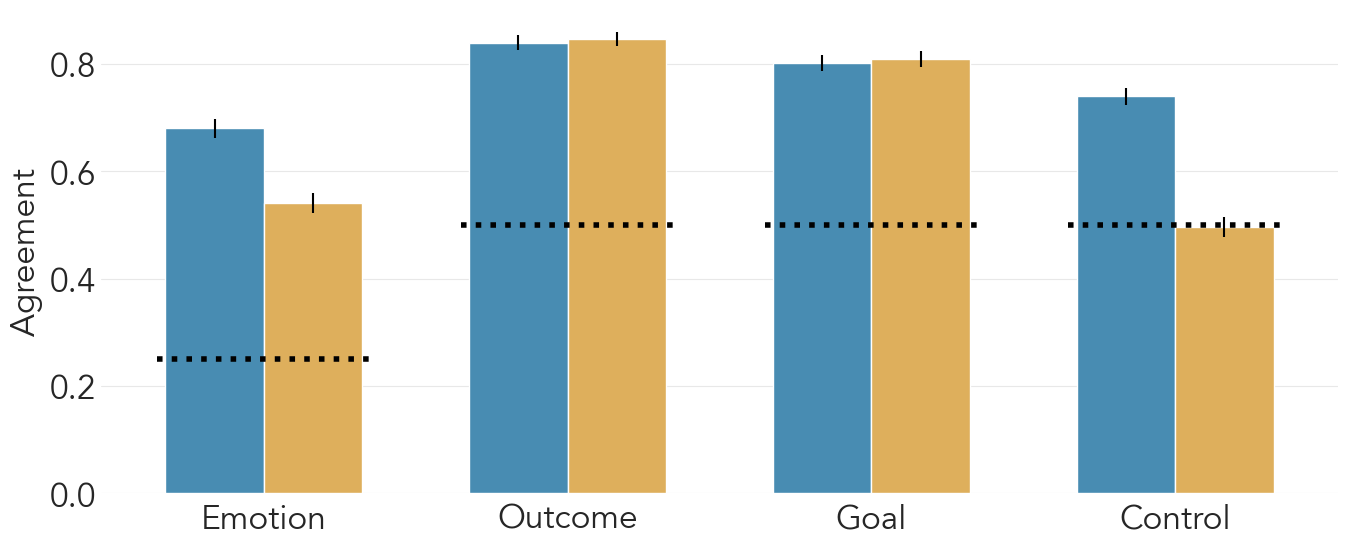

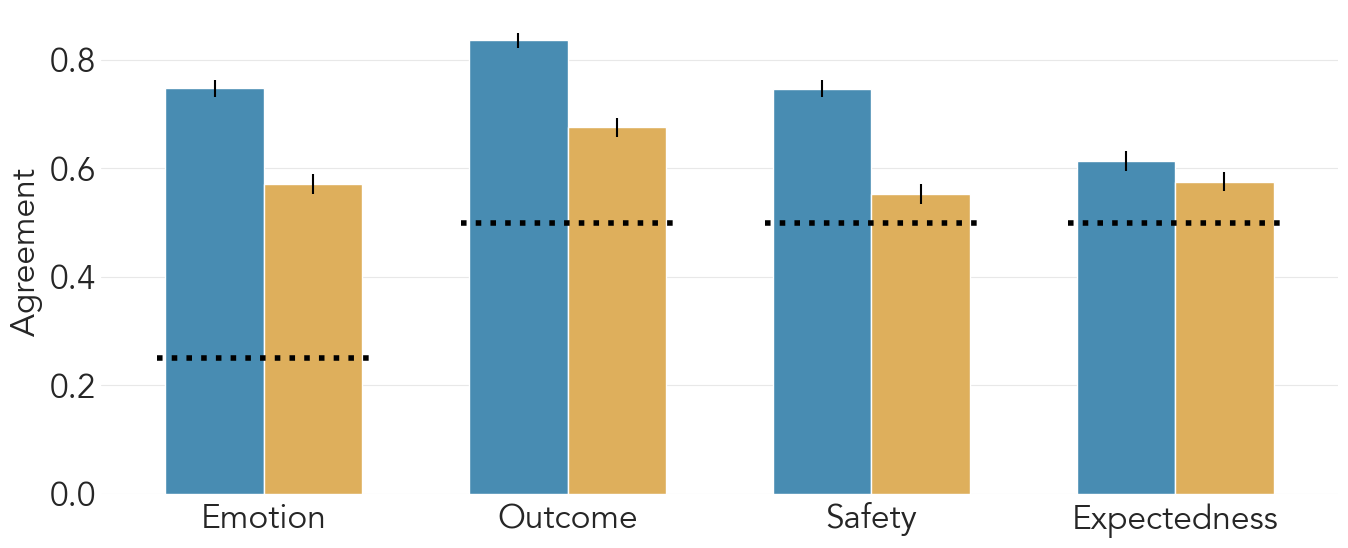

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 24

# keys are save_title, values are the keys in model_means and model_sems
plot_dict = {
    "x_acc_goal_control": ["emotion_inference_goal_control", "outcome_inference_goal_control", "goal_inference", "control_inference"],
    "x_acc_safety_expected": ["emotion_inference_safety_expected", "outcome_inference_safety_expected", "safety_inference", "expected_inference"],
}
# make all plots
for save_title in plot_dict.keys():
    keys = plot_dict[save_title]
    categories = keys

    if "safety" in save_title:
        labels = ["Emotion", "Outcome", "Safety", "Expectedness"]
    elif "goal" in save_title:
        labels = ["Emotion", "Outcome", "Goal", "Control"]


    # Initialize figure
    plt.figure(figsize=(14, 6))
    barWidth = 1.2
    gap = 1.3  # Increase this value to increase space between groups of bars



    # Determine the number of model methods for dynamic positioning
    model_methods = list(model_means.keys())  # Extract model methods from data
    # model_methods = [k for k in model_methods if "partici" not in k]
    print(model_methods)
    num_model_methods = len(model_methods)-1
    num_categories = len(categories)

    # Calculate positions with increased gap
    positions = np.arange(num_categories) * (barWidth * num_model_methods + gap)

    # Adjust the positions for x-ticks to be at the center of each group of bars
    adjusted_positions = positions + (barWidth * (num_model_methods-1)) / 2

    # Color palette

    colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories)
    if num_categories == 1:
        colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories+1)
    if "col" in save_title:
        colorblind_palette = sns.color_palette('colorblind', n_colors=num_categories+4)
    print(len(colorblind_palette))
        
    colorblind_palette = [change_saturation(color, 0.6) for color in colorblind_palette]
    # Plot bars
    for i, method in enumerate(model_methods):
        if method == "chance":
            continue
        print(method, categories)
        
        means = [model_means[method][key] for key in categories]
        sems = [model_sems[method][key] for key in categories]
        j = i
        print(j,i)
        print(len(means))
        print(len(sems))
        plt.bar(positions + i*barWidth, means, yerr=sems, width=barWidth, color=colorblind_palette[j])

        # plt.axhline(model_means["chance"][keys[0]], positions+i*barWidth, barWidth, color='grey', linestyle=':', linewidth=4)
    for j, key in enumerate(categories):
        chance_level = model_means["chance"][key]

        print(key, chance_level)
        plt.hlines(chance_level, positions[j] - barWidth/2-0.1, positions[j] + (num_model_methods - 1) * barWidth + barWidth/2+0.1, color='black', linestyle=':', linewidth=4)

    # draw a dotted line at chance level for each category separately
    # plt.axhline(y=model_means["chance"][keys[0]], color='grey', linestyle=':', linewidth=4)
    # for x1 
    # # for x2
    # plt.axhline(y=model_means["chance"][keys[1]], color='grey', linestyle=':', linewidth=4)
    # # for x2
    # plt.axhline(y=model_means["chance"][keys[2]], color='grey', linestyle=':', linewidth=4)
    # # for expectedness
    # plt.axhline(y=model_means["chance"][keys[3]], color='grey', linestyle=':', linewidth=4)

    # Adjusting the plot
    plt.ylabel('Agreement')
    plt.xticks(adjusted_positions, labels, rotation=0)
    sns.despine(left=True, bottom=True)
    plt.grid(True, which='major', axis='y', linestyle='-', color='lightgrey', alpha=0.5)
    plt.tick_params(axis='y', length=0)
    plt.tight_layout()
    # plt.legend(loc='best', bbox_to_anchor=(0.5, -0.05), ncol=num_categories, fancybox=True, shadow=True)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
    # Show or save plot
    # plt.show()
    plt.savefig(save_title+".png", bbox_inches='tight')  # Uncomment to save the figure
